In [6]:
# Uncomment and run the below
!pip install torch_geometric

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import networkx as nx
from torch_geometric.utils import from_networkx

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Class 1 - Fraud Transaction (Train set)
# Class 2 - True Transaction (Train set)
# Class 0 - Unknown (To predict)

In [9]:
# EDA

In [10]:
# Load your datasets
classes = pd.read_csv("elliptic_txs_classes.csv")
edges = pd.read_csv("elliptic_txs_edgelist.csv")
features = pd.read_csv("elliptic_txs_features.csv", header=None)

# Naming the features columns
features.columns = ["txId", "timeStamp"] + [f"feature{i}" for i in range(1, 166)]

# Preprocess classes and features
classes.loc[classes["class"] == "unknown", "class"] = 0
classes["class"] = pd.to_numeric(classes["class"])

# Merge features and classes
df = pd.merge(classes, features, on="txId")

# Create a graph from the edge list
graph = nx.from_pandas_edgelist(edges, source='txId1', target='txId2')

In [11]:
# Visualization

<BarContainer object of 3 artists>

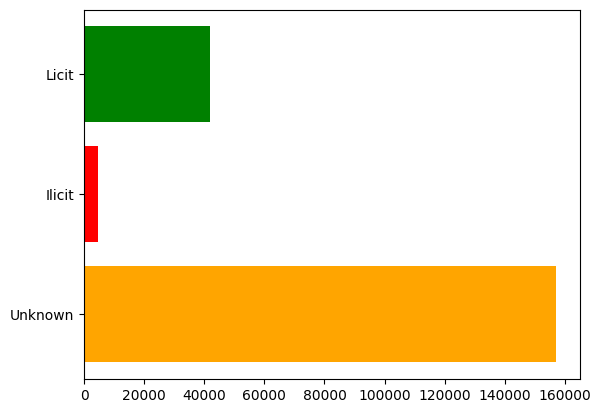

In [16]:
group_class = classes.groupby('class').count()
plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )

In [22]:
df

,txId,class,timeStamp,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,231028831,2,1,-0.171245,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,...,-0.577099,-0.600999,0.241128,0.241406,0.135448,-0.068266,-0.131155,-0.011377,-0.120613,-0.119792
1857,33053378,0,1,-0.170174,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.509843,-0.544232,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1858,37530250,0,1,-0.171414,-0.184668,-1.201369,-0.046932,-0.043875,-0.113002,0.242712,...,0.902544,0.647874,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
1859,230403082,2,1,-0.172921,-0.158783,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.532262,-0.487465,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984


<Axes: >

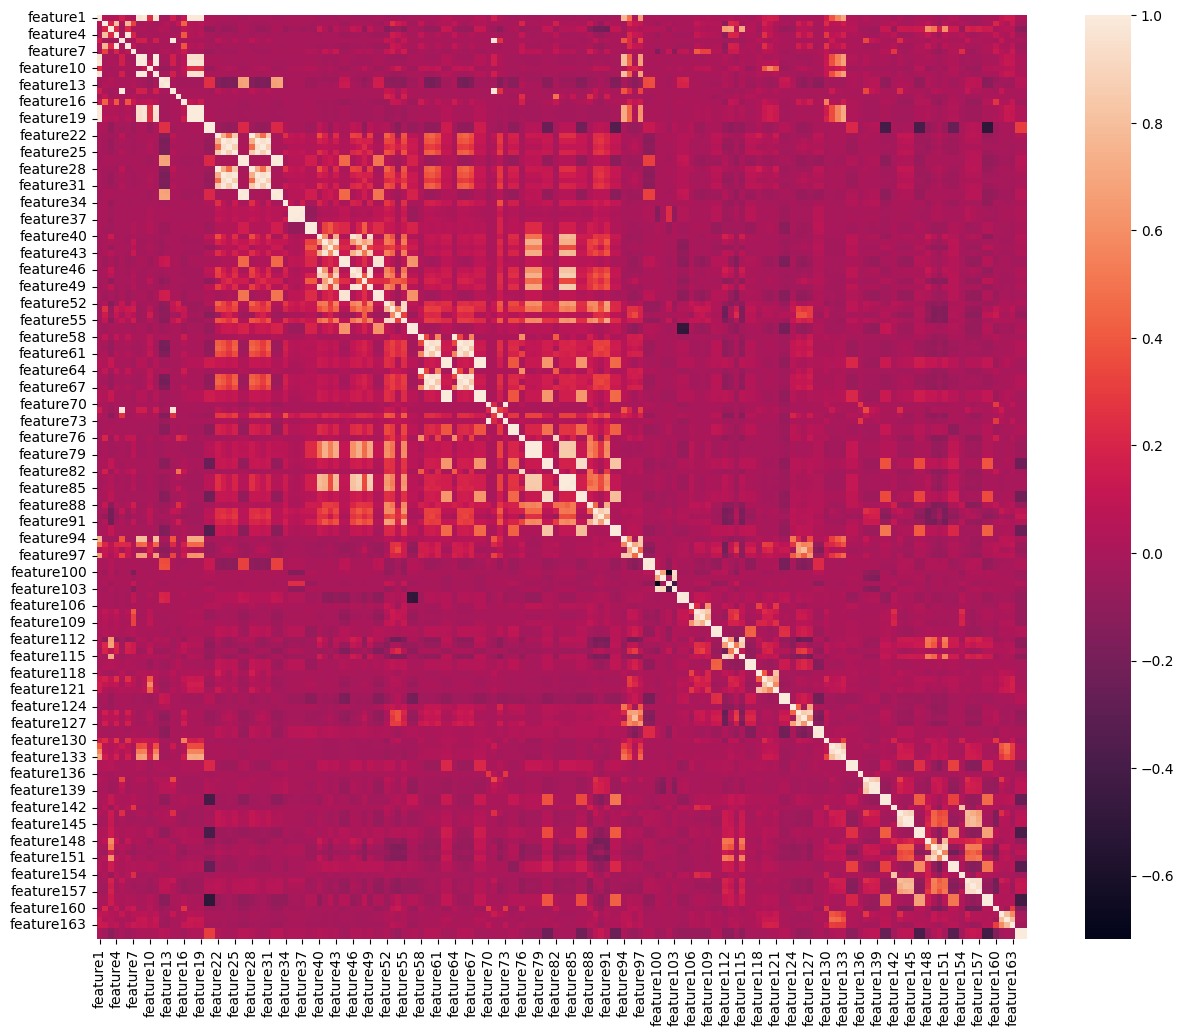

In [30]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.iloc[:,3:].corr())

In [13]:
# Convert to PyTorch Geometric data format
data = from_networkx(graph)

# Assign node features
node_features = torch.tensor(df.iloc[:, 2:].values, dtype=torch.float)  # Features from feature1 to feature166
data.x = node_features

# Ensure data.y is assigned correctly
# Map the node IDs in df to the node indices in data
node_id_to_index = dict(zip(df['txId'], range(df.shape[0])))
labels = df.set_index('txId')['class'].to_dict()

# Create a tensor for node labels
label_tensor = torch.full((len(df),), -1, dtype=torch.long)  # Initialize with -1 for unknown nodes
for node_id, index in node_id_to_index.items():
    if node_id in labels:
        label_tensor[index] = labels[node_id]

data.y = label_tensor

# Check if data.x and data.y were assigned correctly
print(f"Node feature tensor shape: {data.x.shape}")
print(f"Label tensor shape: {data.y.shape}")

Node feature tensor shape: torch.Size([1861, 166])
Label tensor shape: torch.Size([1861])


In [14]:
# Identify and remove rows with NaNs
nan_mask = torch.isnan(data.x).any(dim=1)
data.x = data.x[~nan_mask]
data.y = data.y[~nan_mask]

# Update edge_index to only include valid nodes and remap indices
valid_node_indices = torch.nonzero(~nan_mask).view(-1)
node_map = {idx.item(): i for i, idx in enumerate(valid_node_indices)}
new_edge_index = []
for i, j in data.edge_index.t().tolist():
    if i in node_map and j in node_map:
        new_edge_index.append([node_map[i], node_map[j]])
data.edge_index = torch.tensor(new_edge_index).t().contiguous()

print(f'Updated edge index shape: {data.edge_index.shape}')
print(f'Updated node features shape: {data.x.shape}')
print(f'Updated label tensor shape: {data.y.shape}')


Updated edge index shape: torch.Size([2, 3148])
Updated node features shape: torch.Size([1860, 166])
Updated label tensor shape: torch.Size([1860])


In [15]:
# Define the GNN model
class GNNModel(nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(166, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = nn.Linear(32, 3)  # Output layer for 3 classes (0: unknown, 1: illicit, 2: licit)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training for a few epochs
num_epochs = 200
for epoch in range(num_epochs):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Evaluation
def test():
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index).argmax(dim=1)
        correct = (pred == data.y).sum().item()
        acc = correct / len(data.y)
        return acc

accuracy = test()
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 0, Loss: 1.1074378490447998
Epoch 10, Loss: 0.711053729057312
Epoch 20, Loss: 0.5503330230712891
Epoch 30, Loss: 0.4795686900615692
Epoch 40, Loss: 0.44231170415878296
Epoch 50, Loss: 0.4191713333129883
Epoch 60, Loss: 0.4023452401161194
Epoch 70, Loss: 0.38872087001800537
Epoch 80, Loss: 0.3762269616127014
Epoch 90, Loss: 0.364515483379364
Epoch 100, Loss: 0.35317280888557434
Epoch 110, Loss: 0.34207940101623535
Epoch 120, Loss: 0.33126604557037354
Epoch 130, Loss: 0.3207310438156128
Epoch 140, Loss: 0.3103366792201996
Epoch 150, Loss: 0.30003225803375244
Epoch 160, Loss: 0.28983670473098755
Epoch 170, Loss: 0.27949947118759155
Epoch 180, Loss: 0.2689969539642334
Epoch 190, Loss: 0.25855502486228943
Accuracy: 87.85%
